### Importation de librairies

In [2]:
%matplotlib inline
#Importation de librairies
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#pyplot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot,plot
init_notebook_mode(connected=True)

#Importation de fichiers contenant des fonctions
import dataSource as ds
import dataVisualization as dv

### Lecture du fichier

In [3]:
# Lecture du fichier csv : 1,000,000 premières lignes
df = pd.read_csv("../DataGpsDas.csv", nrows=1000000)

### Trie des données

In [4]:
#On réduit le dataset sur une zone définie
df = df[(df["Latitude"] >= 42.282970-0.003) & (df["Latitude"] <= 42.282970+0.003) 
        & (df["Longitude"] >= -83.735390-0.003) & (df["Longitude"] <= -83.735390+0.003)]

#On prend les trajectoires avec au moins 100 points
trips, counts = np.unique(df["Trip"], return_counts=True)
trips = trips[counts>100]
df = df[df['Trip'].isin(trips)]

#Supprimer les colonnes non utiles
drop_columns = ['Device', 'Time', 'GpsWeek', 'Altitude', 'NumberOfSats', 'Differential', 'FixMode', 'Pdop',
                'GpsBytes', 'UtcTime', 'UtcWeek']
df = df.drop(drop_columns, axis=1)

df

,Trip,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude
120957,268,506824400,239.485600,7.54,42.285965,-83.733940
120958,268,506824600,239.828290,7.49,42.285957,-83.733955
120959,268,506824800,239.733800,7.42,42.285954,-83.733971
120960,268,506825000,239.743190,7.42,42.285946,-83.733986
120961,268,506825200,239.775100,7.38,42.285938,-83.734001
...,...,...,...,...,...,...
997735,28,492287200,60.193279,11.00,42.285923,-83.733826
997736,28,492287400,60.422611,10.99,42.285934,-83.733803
997737,28,492287600,60.365929,10.98,42.285942,-83.733780
997738,28,492287800,60.441559,10.90,42.285954,-83.733749


**Variables centrées réduites**

In [5]:
df['Latitude'] = (df['Latitude'] - df['Latitude'].mean())/df['Latitude'].std()
df['Longitude'] = (df['Longitude'] - df['Longitude'].mean())/df['Longitude'].std()
df['GpsSpeed'] = (df['GpsSpeed'] - df['GpsSpeed'].mean())/df['GpsSpeed'].std()
df['GpsHeading'] = (df['GpsHeading'] - df['GpsHeading'].mean())/df['GpsHeading'].std()
df['GpsTime'] = (df['GpsTime'] - df['GpsTime'].mean())/df['GpsTime'].std()

**Paramètres**

In [6]:
#bins / nombre d'intervalles
n_interval = 8
#récupération de paramètres
lat_min, lat_max, long_min, long_max, e_x, e_y = ds.calcul_param(df, n_interval)

#Ajout des colonnes de l'effectif et de la vitesse moyenne d'une case
e, v, v2 = ds.calcul_eff_vit_moy(df, lat_min, long_min, e_x, e_y,n_interval)
df["Effectif_case"] = e    
df["Vitesse_moy_case"] = v
df["Vitesse_var_case"] = v2

#Affichage du dataframe
df

,Trip,GpsTime,GpsHeading,GpsSpeed,Latitude,Longitude,Effectif_case,Vitesse_moy_case,Vitesse_var_case
120957,268,1.070533,0.295090,0.554161,2.053696,1.169331,1273.0,1.078802,0.648729
120958,268,1.070536,0.298763,0.543117,2.048391,1.156753,1273.0,1.078802,0.648729
120959,268,1.070539,0.297750,0.527656,2.046402,1.143337,1273.0,1.078802,0.648729
120960,268,1.070543,0.297851,0.527656,2.041096,1.130759,1273.0,1.078802,0.648729
120961,268,1.070546,0.298193,0.518821,2.035791,1.118182,1273.0,1.078802,0.648729
...,...,...,...,...,...,...,...,...,...
997735,28,0.829090,-1.626524,1.318381,2.025844,1.264920,181.0,1.414100,0.334055
997736,28,0.829094,-1.624066,1.316172,2.033138,1.284206,181.0,1.414100,0.334055
997737,28,0.829097,-1.624674,1.313963,2.038444,1.303491,181.0,1.414100,0.334055
997738,28,0.829100,-1.623863,1.296293,2.046402,1.329485,181.0,1.414100,0.334055


## Modèles

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from dataSource import *
from sklearn.metrics import mean_squared_error
#fichier contenant des classes pour transformer et evaluer les données
import Eval
from model_physique1 import *
from model_physique1bis import *
from model_physique2 import *
from model_contextual_knnReg import *
from model_physique2 import *

#### Paramètres pour la contruction des jeux de données avec variables centrées réduites

In [8]:
freq_train = range(200, 200*50, 200)
attrs = ['Latitude','Longitude','GpsTime']
l_alpha = []
for fq in freq_train:
    A_pre, A, y_train = create_data_xy2(df,1,fq,fq)
    A_pre = A_pre[attrs].to_numpy()
    A = A[attrs].to_numpy()
    y_train = y_train.to_numpy()
    alpha = learn_alpha(fq,A_pre,A,y_train)
    l_alpha.append(alpha)


coef:  [[-5.71824208e-04  3.82726240e-05]
 [-2.57092967e-05  2.96685081e-07]] (2, 2)
coef:  [[-9.50251511e-04  6.16499135e-05]
 [-4.13862583e-05 -7.94549631e-07]] (2, 2)
coef:  [[-9.68726504e-04  1.21179780e-04]
 [-4.43938322e-05  1.57148275e-06]] (2, 2)
coef:  [[-1.46584144e-03  5.84276873e-05]
 [-6.37152668e-05 -4.55930244e-06]] (2, 2)
coef:  [[-1.67650959e-03  1.02057709e-04]
 [-7.31948853e-05 -3.93732230e-06]] (2, 2)
coef:  [[-1.82160834e-03  1.06407914e-04]
 [-8.33931064e-05 -2.51887706e-06]] (2, 2)
coef:  [[-1.57011647e-03  3.06920122e-04]
 [-7.24384071e-05  4.34446786e-06]] (2, 2)
coef:  [[-2.64738109e-03 -3.19426357e-05]
 [-1.33689951e-04 -1.09186542e-05]] (2, 2)
coef:  [[-1.79573314e-03  2.01770072e-04]
 [-8.74048059e-05 -2.55581419e-06]] (2, 2)
coef:  [[-1.83915650e-03  1.66171547e-04]
 [-8.75106841e-05 -7.23348435e-06]] (2, 2)
coef:  [[-2.03655395e-03  4.58357491e-05]
 [-1.00313784e-04 -1.42848829e-05]] (2, 2)
coef:  [[-2.40273760e-03  1.57441113e-04]
 [-1.08574206e-04 -8.37

In [9]:
#on prend un point sur 'step' du jeu de données
freq_test = 800
freq_train = 400

train_size = 0.7

attrs = ['Trip','Latitude','Longitude','GpsHeading','GpsTime']
#features
attrs_x = [['Latitude','Longitude','GpsHeading','GpsSpeed'],['Latitude','Longitude','GpsTime'],['Latitude','Longitude','GpsHeading','GpsTime'],attrs]
#attrs_x = [['Latitude','Longitude','GpsHeading','GpsTime'],attrs]

#attrs_x = [attrs,attrs,attrs]
#targets
labels = ['Latitude','Longitude']

#models
#models = [model_physique1bis(l_alpha, iftheta=False),model_physique1bis(l_alpha,iftheta=True),model_physique1()]
models = [model_contextual_knnReg(),model_contextual_knnReg(),LinearRegression(),model_physique1()]
#models = [LinearRegression(),model_physique1()]

#preprocessing
#preprocessor = [MinMaxScaler() for _ in range(len(models))]
preprocessor = None

#### Création des données d'apprentissage et de test et évaluation des modèles

In [10]:
#création des données d'apprentissage et de test pour la prédiction du prochain point (à partir de toutes nos données)
traitement = Eval.Traitement(df, attrs_x, labels, freq_train, freq_train,preprocessor)
traitement.set_data_train_test(train_size)

#Apprentissage des modèles et évaluation à partir de l'objet traitement
evaluateur = Eval.Evaluation(models,traitement)
evaluateur.fit()

#Affichage des résultats
evaluateur.afficher_resultats()


MSE sur les données de test:

MSE obtenue pour model_contextual_knnReg : 0.02296977436114354
MSE obtenue pour model_contextual_knnReg : 0.2688088703146895
MSE obtenue pour LinearRegression : 0.006699091262920618
MSE obtenue pour model_physique1 : 0.006757754661062591



#### Tableau d'erreurs en fonction de la fréquence

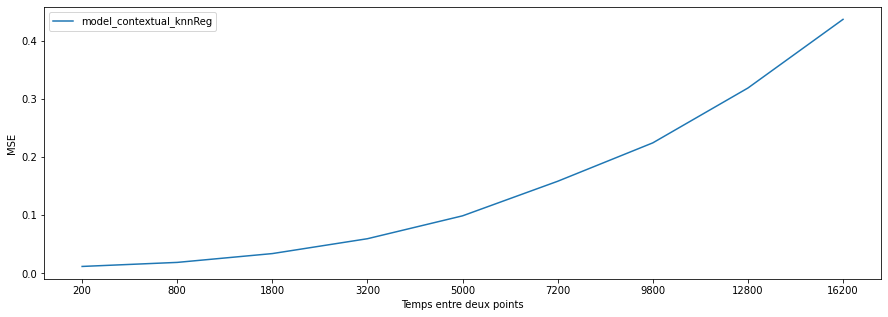

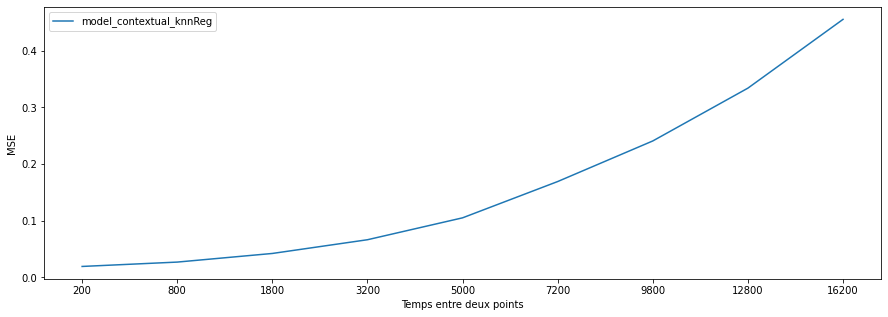

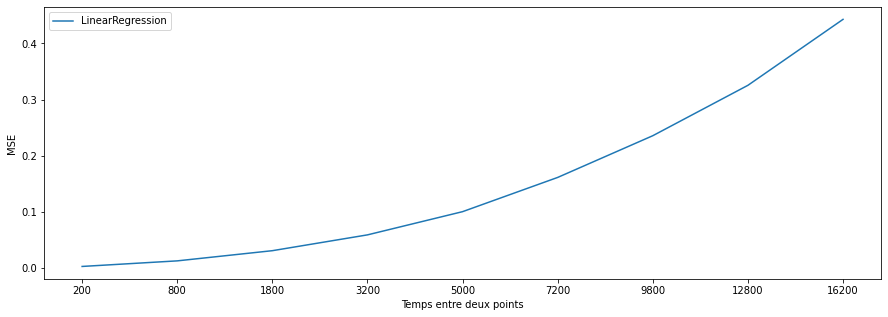

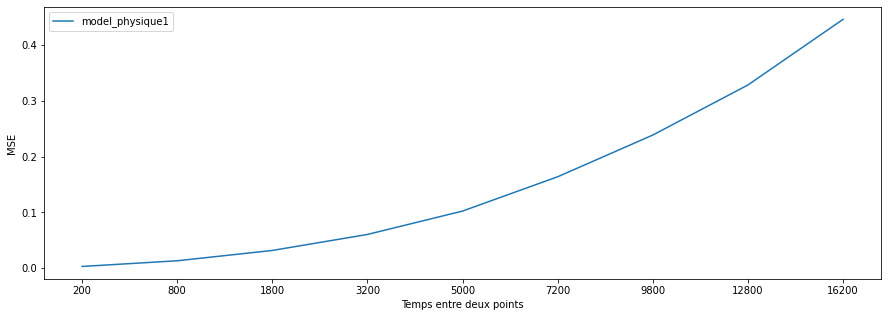

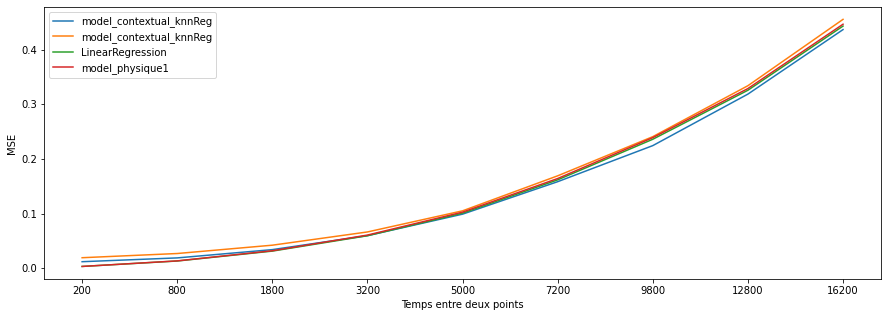

,model_contextual_knnReg,model_contextual_knnReg,LinearRegression,model_physique1
200,0.011886,0.019176,0.003232,0.003214
800,0.018840,0.026865,0.013157,0.013385
1800,0.033991,0.042097,0.031271,0.031905
3200,0.059541,0.066319,0.059410,0.060591
5000,0.098869,0.104962,0.100717,0.102538
7200,0.158260,0.169006,0.161624,0.164042
9800,0.224244,0.240642,0.235871,0.238845
12800,0.318475,0.333835,0.325526,0.328608
16200,0.436466,0.455191,0.442894,0.446295


In [20]:
nb_freq = 10
freq_test = [200*(i**2) for i in range(1,nb_freq)]

tabMSE = evaluateur.tabMSEFreq(freq_test,freq_train)
tabMSE

In [12]:
xtest = evaluateur.l_Xtest
ytest = evaluateur.l_Ytest
b = 260
e = 280


for mi in range(2,len(models)):
    ypred = models[mi].predict(xtest[mi])[b:e]
    print(f"{type(models[mi]).__name__} {np.sum(np.mean((ypred-ytest[mi].iloc[b:e])**2))}")

LinearRegression 0.00012951363716954284
model_physique1 0.00022308357789818965


In [13]:
evaluateur.l_Xtest[0]

,Latitude,Longitude,GpsHeading,GpsSpeed
861675,-0.342295,2.454760,0.598151,1.305128
861677,-0.342295,2.417027,0.597138,1.258745
861679,-0.342295,2.371748,0.604133,1.199109
861681,-0.344284,2.327307,0.601053,1.112969
861683,-0.344284,2.288735,0.604627,1.044498
...,...,...,...,...
997729,1.988044,1.150045,-1.631742,1.289667
997731,2.000644,1.188616,-1.631011,1.300711
997733,2.013244,1.227187,-1.629103,1.302919
997735,2.025844,1.264920,-1.626524,1.318381


In [14]:
nb_points = 100
begin_point = np.random.randint(0,13690-nb_points)
end_point = begin_point+nb_points
evaluateur.scatterPred(begin_point,end_point)

[0.03969276423665391,
 4.476988275394643,
 0.010762277606128544,
 0.0035018312615304453]

In [15]:
print(type(models[1]).__name__)
models[1].predict(evaluateur.l_Xtest[1])[begin_point:end_point]

model_contextual_knnReg


array([[ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548, -0.36010349],
       [ 0.24990548,

In [16]:
print(type(models[3]).__name__)
models[3].predict(evaluateur.l_Xtest[3])[begin_point:end_point]

model_physique1


array([[ 0.21940019,  0.12622972],
       [ 0.21940019,  0.12622972],
       [ 0.21940019,  0.12036018],
       [ 0.21940019,  0.11365213],
       [ 0.21940019,  0.10694409],
       [ 0.21674756,  0.09436651],
       [ 0.21674756,  0.08849697],
       [ 0.21674756,  0.07508088],
       [ 0.21674756,  0.06921134],
       [ 0.21674756,  0.05579525],
       [ 0.21674756,  0.04321767],
       [ 0.21475808,  0.03064009],
       [ 0.21475808,  0.0180625 ],
       [ 0.21475808,  0.01135446],
       [ 0.21475808, -0.00122312],
       [ 0.21475808, -0.00793117],
       [ 0.21475808, -0.01463921],
       [ 0.21475808, -0.0272168 ],
       [ 0.21475808, -0.03308633],
       [ 0.21475808, -0.03979438],
       [ 0.21475808, -0.04650242],
       [ 0.21475808, -0.05237196],
       [ 0.21475808, -0.05237196],
       [ 0.21475808, -0.05908001],
       [ 0.21475808, -0.06578805],
       [ 0.21475808, -0.06578805],
       [ 0.21475808, -0.07165759],
       [ 0.21475808, -0.07165759],
       [ 0.21475808,

In [17]:
print(type(models[2]).__name__)
models[2].predict(evaluateur.l_Xtest[2])[begin_point:end_point]

LinearRegression


array([[ 0.22007152,  0.11746744],
       [ 0.22007152,  0.11746743],
       [ 0.22007153,  0.11746741],
       [ 0.22004704,  0.11779581],
       [ 0.21999604,  0.11136351],
       [ 0.21996329,  0.11180264],
       [ 0.21992745,  0.10605661],
       [ 0.21989187,  0.09941759],
       [ 0.21987085,  0.09258347],
       [ 0.21717244,  0.07994913],
       [ 0.21715531,  0.07395223],
       [ 0.21709321,  0.06055272],
       [ 0.21707632,  0.05455255],
       [ 0.2170111 ,  0.04119492],
       [ 0.21695504,  0.0286039 ],
       [ 0.21491009,  0.01607583],
       [ 0.21485045,  0.00353289],
       [ 0.21483517, -0.00337836],
       [ 0.21477255, -0.01588136],
       [ 0.21474501, -0.02262825],
       [ 0.21469424, -0.02906353],
       [ 0.21464725, -0.04177621],
       [ 0.21463424, -0.0478282 ],
       [ 0.2146037 , -0.05453483],
       [ 0.21458487, -0.06139839],
       [ 0.21454782, -0.06712828],
       [ 0.2145553 , -0.06722848],
       [ 0.21454347, -0.07418582],
       [ 0.2145086 ,

In [18]:
evaluateur.l_Ytest[3].iloc[begin_point:end_point]

,Latitude,Longitude
974309,0.219400,0.126230
974311,0.219400,0.120360
974313,0.219400,0.113652
974315,0.219400,0.106944
974317,0.216748,0.094367
...,...,...
974499,0.376569,-0.251098
974501,0.394474,-0.256967
974503,0.414369,-0.256967
974505,0.434927,-0.256967


#### Matrice erreurs MSE pour chaque case

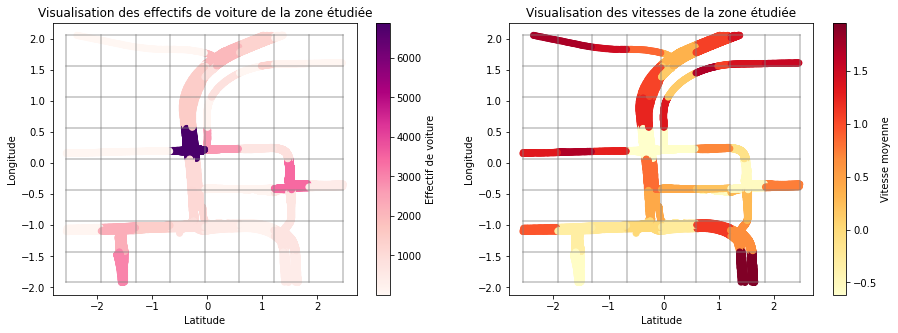

ValueError: Found input variables with inconsistent numbers of samples: [878, 876]

In [19]:
min_datapoints = 5

#fréquences
freq_train = 400
freq_test = freq_train

dv.afficher_traffic(df, lat_min,lat_max, long_min, long_max, n_interval)

#On apprend sur toutes les données puis on prédit et calcule l'erreur MSE sur chaque case
evaluateur.matMSECase(freq_train,freq_test,lat_min,long_min,e_x,e_y,min_datapoints,train_size,n_interval)